## Clustering Morphologies Using [Persistent Homology](https://en.wikipedia.org/wiki/Topological_data_analysis)

The distance metric is a p-norm between persistence landscapes computed from persistence diagrams, where the diagrams (collections of birth-death pairs) are generated via sublevel set filtrations over neuronal trees with respect to some morphological descriptor function. See [Kanari, L., Dłotko, P., Scolamiero, M. et al. A Topological Representation of Branching Neuronal Morphologies. Neuroinform 16, 3–13 (2018)](https://link.springer.com/article/10.1007/s12021-017-9341-1) for the general filtration algorithm.

For a primer on persistence landscapes, see [Bubenik, P.. (2015). Statistical topological data analysis using persistence landscapes. Journal of Machine Learning Research. 16. 77-102. ](http://jmlr.org/papers/v16/bubenik15a.html)

We can compute both persistence diagrams and landscapes directly from neuronal reconstructions using SNT's [PersistenceAnalyzer](https://javadoc.scijava.org/SNT/index.html?sc/fiji/snt/analysis/PersistenceAnalyzer.html) class

As usual, we 1) initialize Fiji with GUI support (see [Overview](1_overview.ipynb) for details on how to link your local Fiji installation to this notebook); 2) import all relevant python modules; and 3) import all relevant SNT classes:

In [1]:
import os
import ijfinder
import imagej

fiji_path = ijfinder.getpath().decode('utf-8')
if os.path.isdir(fiji_path):
    ij = imagej.init(fiji_path, mode='interactive')
else:
    print("Cannot proceed: Fiji not found!")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [3]:
from scyjava import jimport
MouseLightLoader = jimport('sc.fiji.snt.io.MouseLightLoader')
PersistenceAnalyzer = jimport('sc.fiji.snt.analysis.PersistenceAnalyzer')
AllenUtils = jimport('sc.fiji.snt.annotation.AllenUtils')
Viewer3D = jimport('sc.fiji.snt.viewer.Viewer3D')
ColorTables = jimport('net.imagej.display.ColorTables')

In [4]:
def fetch_reconstructions(id_list, group_label):
    tree_list = []
    for tree_id in id_list:
        loader = MouseLightLoader(tree_id)
        if not loader.isDatabaseAvailable(): 
            print("Database not available. Exiting...")
            continue
        if not loader.idExists(): 
            print("Id not found in database. Exiting...")
            continue
        tree = loader.getTree()
        tree_map[tree.getLabel()[0:6]] = tree
        tree.setLabel(tree.getLabel() + ' ' + group_label)
        tree_list.append(tree)
        
    return tree_list


def get_landscapes(trees, num_landscapes, resolution):
    landscapes = []
    for tree in trees:  
        """
        Obtain the Persistence Landscape as a N-dimensional vector,
        where N == number of landscapes x resolution.
        We use the radial distance descriptor function,
        which measures the euclidean distance between a node and 
        the root node of the tree.
        The available descriptor functions may be retrieved by calling
        PersistenceAnalyzer.getDescriptors()
        """
        ls = PersistenceAnalyzer(tree).getLandscape('radial', num_landscapes, resolution)
        landscapes.append(ls)
        
    return np.array(landscapes)


def plot_dendrogram(model, group_labels):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, color_threshold=3500, orientation='right', labels=group_labels)


def hcluster(mat, group_labels):
    # The Chebyshev distance between persistence landscapes is stable
    # with respect to the bottleneck distance between persistence diagrams.
    model = AgglomerativeClustering(affinity='chebyshev', linkage='complete', distance_threshold=0, n_clusters=None)
    model = model.fit(mat)
    fig, ax = plt.subplots(figsize=(10, 13))
    plt.title('Hierarchical Clustering Dendrogram')
    plot_dendrogram(model, group_labels)
    plt.show()


def get_group_trees(compare):
    groups = []
    for pair in compare:
        p = [tree_map[pair[0]], tree_map[pair[1]]]
        groups.append(p)
    return groups

Two types of mouse neuron from Layers 5 and 6 of motor cortex with differing projection patterns described in 
Winnubst et al. Cell 2019  
pre print at https://www.biorxiv.org/content/10.1101/537233v1

The first group is comprised of Layer 6 Corticothalamic neurons, which project primarily to Thalamus.

The second group contains Layer 5 pyramidal tract neurons, which may be further subdivided into two groups 
based on projection targets: 
One sub-type projects predominantly to Thalamus, while the other projects to Medulla.

The two sub-types of Layer 5 PT neuron have distinct transcriptional profiles and functional roles, which are
elucidated in Economo et al. Nature 2018.  
pre-print at https://www.biorxiv.org/content/10.1101/229260v1

In [5]:
tree_map = {}

corticothalamic = ['AA0039', 'AA0101', 'AA0103', 'AA0105', 'AA0188', 'AA0278', 'AA0390',
                   'AA0394', 'AA0406', 'AA0577', 'AA0599', 'AA0633', 'AA0650', 'AA0781', 
                   'AA0784', 'AA0799','AA0817', 'AA0837', 'AA0838', 'AA0844']

pt_medulla = ['AA0012', 'AA0131', 'AA0133', 'AA0134', 'AA0169', 'AA0179', 'AA0180', 'AA0576',
              'AA0788', 'AA0923']

pt_thalamic = ['AA0011', 'AA0114', 'AA0115', 'AA0122', 'AA0181', 'AA0182', 'AA0245', 'AA0261',
               'AA0415', 'AA0617', 'AA0764', 'AA0780', 'AA0792', 'AA0926']

We can fetch all of these cells from the [MouseLight database](https://ml-neuronbrowser.janelia.org/) using SNT's [MouseLightLoader](https://morphonets.github.io/SNT/sc/fiji/snt/io/MouseLightLoader.html) class

In [6]:
corticothalamic_trees = fetch_reconstructions(corticothalamic, 'Layer 6 CT')
pt_thalamic_trees = fetch_reconstructions(pt_thalamic, 'Layer 5 PT-THAL')
pt_medulla_trees = fetch_reconstructions(pt_medulla, 'Layer 5 PT-MED')

In [7]:
all_trees = corticothalamic_trees + pt_thalamic_trees + pt_medulla_trees
all_labels = [t.getLabel() for t in all_trees]

Now compute the persistence landscapes for all cells

In [8]:
num_landscapes = 500
resolution = 500
landscapes = get_landscapes(all_trees, num_landscapes, resolution)

Let's visualize the persistence landscape for one reconstruction

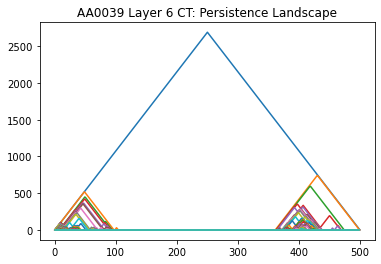

In [9]:
ls_split = np.array(np.split(landscapes[0], num_landscapes))
plt.plot(np.arange(resolution), ls_split.T)
plt.title("{}: Persistence Landscape".format(all_trees[0].getLabel()))
plt.show()

We can perform hierarchical clustering on the landscape matrix and plot a dendrogram

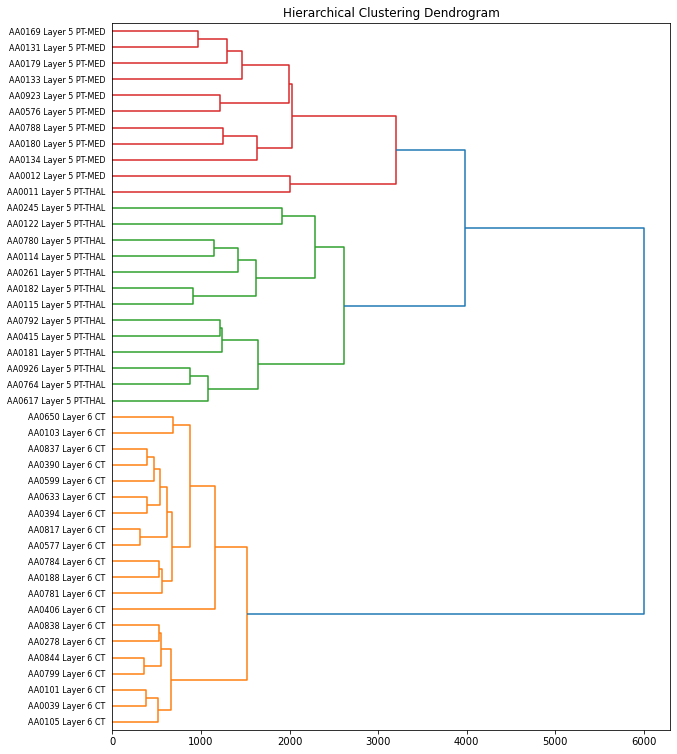

In [10]:
hcluster(landscapes, all_labels)

Lets visualize a pair of neighboring cells in each clustered cell-type

In [11]:
compare = [['AA0245', 'AA0122'], ['AA0788', 'AA0180'], ['AA0101', 'AA0039']]
groups = get_group_trees(compare)

# We can also retrieve meshes of the relevant Allen CCF compartments
somatomotor_mesh = AllenUtils.getCompartment("Somatomotor areas").getMesh()
thalamus_mesh = AllenUtils.getCompartment("Thalamus").getMesh()
medulla_mesh = AllenUtils.getCompartment("Medulla").getMesh()

Layer 5 Pyramidal tract, Thalamic projecting

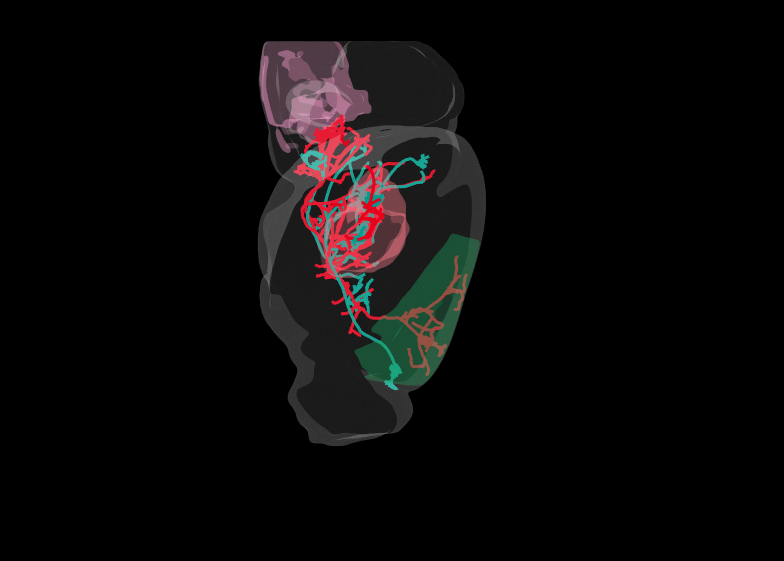

In [12]:
v = Viewer3D()
v.loadRefBrain('mouse')
v.setViewMode('sagittal')
v.add(ij.py.to_java([somatomotor_mesh, thalamus_mesh, medulla_mesh]))
v.addTrees(groups[0], True)
v.colorCode([t.getLabel() for t in groups[0]], 'length', ColorTables.ICE)
v.updateView()
v.show()

# To embed the snapshot in this notebook
# from IPython.display import Image, display
# snapshot_path = os.getcwd() + '/images/group0exemplars.png'
# v.saveSnapshot(snapshot_path)
# display(Image(filename=snapshot_path))

v.removeAllTrees()

Layer 5 Pyramidal tract, Medulla projecting

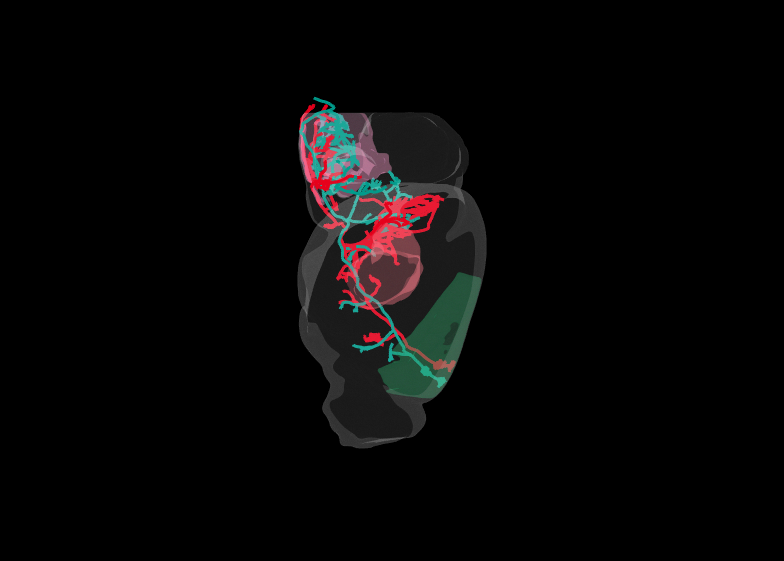

In [13]:
v.addTrees(groups[1], True)
v.colorCode([t.getLabel() for t in groups[1]], 'length', ColorTables.ICE)

# To embed the snapshot in this notebook
# snapshot_path = os.getcwd() + '/images/group1exemplars.png'
# v.saveSnapshot(snapshot_path)
# display(Image(filename=snapshot_path))

v.removeAllTrees()

Layer 6 Corticothalamic

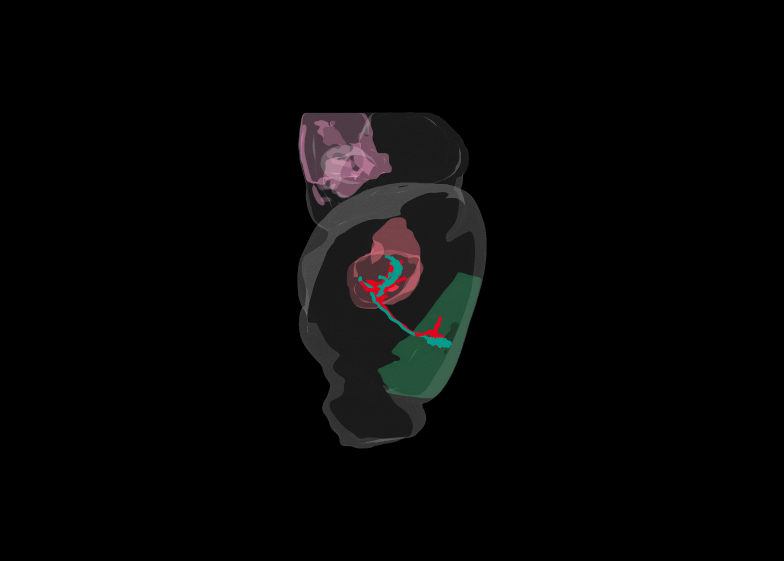

In [14]:
v.addTrees(groups[2], True)
v.colorCode([t.getLabel() for t in groups[2]], 'length', ColorTables.ICE)

# To embed the snapshot in this notebook
# snapshot_path = os.getcwd() + '/images/group2exemplars.png'
# v.saveSnapshot(snapshot_path)
# display(Image(filename=snapshot_path))